In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
udemy_folder = "/content/drive/MyDrive/0_MAESTRIA/1_TEXT/TM_udemy_reviews"
!cp {udemy_folder}/udemy_reviews.zip udemy_reviews.zip

Mounted at /content/drive


#### Load the libraries

In [2]:
!pip3 install -q -U spacy
!python3 -m spacy download es_core_news_md

     |████████████████████████████████| 43.4 MB 61 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.options.display.float_format = "{:,.2f}".format

### Connect to drive to get the data

In [4]:
df_udemy = pd.read_csv(f'udemy_reviews.zip', compression='zip', header=0, sep=',', quotechar='"')
df_udemy.head()

,id,course,rating,comment,user
0,73015398,1640654,2.50,como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,Jorge Alejandro Castillo
1,50586814,1640654,4.50,Los conocimientos son claros y concisos para lo requerido,Jaime Medina
2,49880684,1640654,5.00,hermoso,Adrián Antonio Herrera Castro
3,47366486,1640654,5.00,Excelente !!!,Márcio Maurício Soares do Nascimento
4,79933910,88380,5.00,Excelente todo!,Emilio Monarrez Hernandez


In [5]:
df_news = df_udemy

In [6]:
# Aplica pos/neg
df_news['tag']=df_news['rating'].apply(lambda x: 'pos' if x >= 4 else 'neg')
# Filtra los que solamente dicen una palabra (ej. "Excelente!")
#df_news = df_news[df_news['comment'].str.contains("\s")]
# Filtra los que tienen menos de 5 palabras
df_news = df_news[df_news['comment'].str.split().str.len().gt(4)]
# Filtra los que dicen menos de 12 letras (ej. "Excelente!")
df_news = df_news[df_news['comment'].str.len() >= 12]
df_news = df_news[df_news['tag']=='neg']#.sample(2000)

df_news.reset_index(inplace=True)
display(df_news.sample(10))

# Recomendación:
# usar los comentarios con >=5 palabras


,index,id,course,rating,comment,user,tag
6241,57363,95261634,1163506,3.00,"Está bien para una persona que comienza desde 0, ya que comparte conocimientos muy básicos.",Laura Alvarez,neg
14798,137188,29741126,1171414,3.00,Lo mejor el material extra de la Sección 2.\nLo peor es que el profesor habla demasiado rápido y a veces no se le entiende. Los subtítulos lo confirman.,José Manuel Martínez Torres,neg
13959,128115,54087650,1803800,3.00,Contenidos muy escasos y breves.,Mihaela Cristina Manasturean,neg
2508,22633,64780812,2721046,1.50,"HASTA DONDE VA NO ES CURSO,SOLO HABLA Y HABLA Y HABL.......",Maria de los angeles,neg
13003,120091,75096070,1717394,3.50,El volumen en ocasiones bajaba y pues el curso es muy bueno teóricamente. Recomiendo agregar ejemplos de ejercicios,Alfredo Villagomez Muciño,neg
3936,35619,62811654,902626,1.50,At the beginning was a good course and well explained but since the fourth section it was awful and poor at the time of explaining,Christopher J Rodriguez Cerritos,neg
223,2134,88722612,1125322,3.50,"Si en general, a veces se torna un poco lento y algunas pocas presentaciones no cuadran con el relato.",Felipe Ariste,neg
6733,60905,22567884,1165924,3.00,"Ejemplos muy simplificados, sin demasiada explicación.",Iván Carrillo,neg
6894,62508,93269434,3855396,3.00,"Conceptos muy vagos sobre las cosas, o sea sirve para empezar, pero luego tienes que investigar mucho por tu cuenta, pero muchisimo. Otros cursos por el mismo precio te dan toda la informacion necesaria. No esta mal, pero podria ser mejor, o al menos ser igual pero muchisimo mas barato.",Pablo Groba,neg
477,4218,41222580,1821588,2.00,No me gustaron muchos los ejemplos,Estefanny Yuridia Cruz Rodríguez,neg


In [7]:
df_news[df_news['id'].isin([76629358,52215828])]

,index,id,course,rating,comment,user,tag
988,9035,52215828,1922200,3.00,"El contenido es claro e interesante, ya he tomado un par de cursos con Fabian y me han sido de mucha utilidad. Encontré deficiencias en el material de apoyo y la sección 22. El lanzamiento no fue muy clara, pero en general se adquiere un gran conocimiento de scrum scale",Diana Forero,neg
5991,54928,76629358,3446356,3.50,"Buenos días, si estás leyendo este comentario, te recomiendo leerlo entero para tener un contexto global del por que dejo solo 3 estrellas. Primero dejaré unos puntos clave y luego la explicación.\n\nPrólogo: Enhorabuena a Nicolas Schurmann por su trabajo y acercar a más gente al mundo del desarrollo, y enhorabuena por el curso que pese a no cuadrar conmigo está muy bien.\n\nPrimero: El curso lo recibí de forma gratuita por una promoción.\nSegundo: Lo explicado en el curso, está bien explicado.\nTercero: Recomiendo el curso a cualquier persona que no tenga ningún conocimiento del mundo de desarrollo.\nCuarto: No recomiendo el curso a las personas que ya tengan contacto con el mundo del desarrollo. \nQuinto: Soy desarrollador Junior trabajando con lenguajes POO como Java y C# en mi día a día. \nSexto: A la hora de escribir este comentario miré y practiqué hasta la sección 12 (inclusive).\n\nExposición: \nEl título expone muchas tecnologías, cosa que ya me decía que faltarían aspectos interesantes por tocar, yo ya se lo básico de HTML, CSS y algo más avanzado en MySQL, no se que es Flask y no conocía la sintaxis de Python. Mi interés en este curso es principalmente Python, nada más, aún que veré el resto de secciones por si acaso. \n\nDicho esto la sección de Python me parece demasiado básica, echando en falta explicación de conceptos como; ámbito de vida de las variables, uso de variables de forma global, funcionamiento extendido a la hora de iterar diccionarios y otro tipo de colecciones, propagación de excepciones y algunos temas más avanzados. \n\nPilares de la OO, se explica la creación de clases y su herencia, pero no se explican conceptos como el polimorfismo que me parece de vital importancia en la POO, tampoco se hace mención a la abstracción y el encapsulamiento, pese a explicar la creación de funciones en clases al ser python un lenguaje no tipado (o poco tipado) no queda claro el tema del encapsulamiento, no se explica en el curso, en las clases creadas siempre se tiene acceso a las propiedades y eso va en contra de este principio.\n\nEn un capítulo se explica la recursividad, es algo muy potente pero que si no se tienen conocimientos puede dar pie a confusión y errores, desearía algún ejemplo más de recursividad para los más inexpertos. \n\nEn resumen, falta un poco de explicación teórica sobre los principios de la POO y falta algo más de contenido sobre Python, lo explicado está perfectamente explicado (menos la recursividad en mi opinión). \n\nCon el título ""python sin fronteras"" esperaba mucho más contenido sobre python, como dije el curso lo recomiendo a cualquier persona que quiera iniciarse, pero si ya controlas aún que sea como junior algún lenguaje de programación, no creo que este curso sea para ti. \n\nMe sabe mal dejar tan baja puntuación a Nicolas Schurmann por que su contenido es muy bueno, tanto en esta plataforma como en otras, pero no me queda más remedio que ser objetivo, quizás si el título fuera algo así como ""Iniciación en Python"" o algo similar no hubiera escrito este comentario y le hubiera dado 4.5 estrellas o 5, ya que es 100% apto para los no iniciados. \n\nSin más me despido, un saludo y espero os toméis este comentario como lo que es, un comentario que intenta dar un punto de vista como un junior que quiere aprender.",Ramón Martínez Nieto,neg


In [8]:
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
# from gensim.models.wrappers import LdaMallet


In [9]:
df_news['tag'].value_counts()

neg    18883
Name: tag, dtype: int64

In [10]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18883 entries, 0 to 18882
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    18883 non-null  int64  
 1   id       18883 non-null  int64  
 2   course   18883 non-null  int64  
 3   rating   18883 non-null  float64
 4   comment  18883 non-null  object 
 5   user     18882 non-null  object 
 6   tag      18883 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 1.0+ MB


#Data Preprocessing

We defined a list of custom words to be exclude from our dataset

Create the cleaner function to clean the spanish text, remove non alpha numeric characters, remove duplicate, remove spanish accutes, remove digits

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

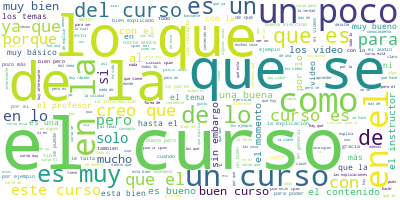

In [12]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df_news['comment'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


In [13]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('spanish'))

black_list = ['excelente', 'buen','bien',
              'muchas', 'gracias', 'curso','course','good'
              ]

additional_stopwords=set(black_list)

stopwords_sp = stop.union(additional_stopwords)

from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')
def stemmization(texts):
    texts = re.sub(r"""
                   [,.;@#?!&$]+  # Accept one or more copies of punctuation
                   \ *           # plus zero or more copies of a space,
                   """,
                   " ",          # and replace it with a single space
                   texts, flags=re.VERBOSE)
    return spanish_stemmer.stem(texts).split()


import spacy
nlp = spacy.load('es_core_news_md')
def lemmatization(texts, allowed_postags=['NOUN']):
    #x = nlp(texts)
    #print([(xx.text,xx.pos_) for xx in x])
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out

In [14]:
%%time
bigram = gensim.models.Phrases(df_news['comment'].to_list()) 

CPU times: user 3.93 s, sys: 8.7 ms, total: 3.94 s
Wall time: 3.93 s


In [15]:
def cleaner(word):
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
    word = re.sub(r'ee.uu', 'eeuu', word)
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', ' ', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.{3}', ' ', word)
    word = re.sub(r'a{2,}', 'a', word)
    word = re.sub(r'é{2,}', 'é', word)
    word = re.sub(r'i{2,}', 'i', word)
    word = re.sub(r'ja{2,}', 'ja', word) 
    word = re.sub(r'á', 'a', word)
    word = re.sub(r'é', 'e', word)
    word = re.sub(r'í', 'i', word)
    word = re.sub(r'ó', 'o', word)
    word = re.sub(r'ú', 'u', word)  
    word = re.sub('[^a-zA-Z]', ' ', word)
    wordlist = [ token for token in nltk.word_tokenize(word) if token.lower() not in stopwords_sp and len(token)>3 ]
    wordlist = [x for x in wordlist if not any(string for string in black_list if string in x)]
    word = " ".join(wordlist)
    list_word_clean = []
    for w1 in word.split(r"\s"):
        if  w1.lower() not in stopwords_sp:
            list_word_clean.append(w1.lower())

    bigram_list = bigram[list_word_clean]
    out_text = stemmization(" ".join(bigram_list))
    return out_text

In [16]:
cleaner('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción	')

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['amigo',
 'adentraste',
 'informaste',
 'publicar',
 'mejor',
 'facebook',
 'recomendacion',
 'mejora',
 'diccion']

Create the function for select **only nouns** for our data, this way we are removing adverb, adjetives, verbs, etc. This is doing with spacy

For gensim we need a list of text, so we need do convert the dataframe to list

In [17]:
stemmization('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción')

['curso',
 'gracias',
 'amigo',
 'me',
 'adentraste',
 'e',
 'informaste',
 'como',
 'publicar',
 'mejor',
 'en',
 'facebook',
 'ads',
 'recomendacion',
 'mejora',
 'tu',
 'diccion']

In [18]:
lemmatization('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción	')

['amigo', 'recomendación', 'dicción']

In [19]:
len(df_news)

18883

In [20]:
# !python -m spacy download es_core_news_md

In [21]:
df_news['comment'].sample(3)

18095    Creo que es un buen curso pero debo familiarizarme con la terminología, pues aunque es español parece que la presentación es de una traducción hecha en España con comentarios verbales (en los casos de comentarios adicionales) provenientes del habla Argentina. en algunas láminas (hojas, slides de la Presentación o video) me gustaría que el audio no fuera solo la lectura sino comentarios adicionales. Atentamente
12866                                                                                                                                                                                                                                                                                                                                      Los videos son aburridos, creo que podrían hacerlos más dinámicos y con diferentes imágenes
179                                                                                                                                                       

In [22]:
cleaner(df_news['comment'].iloc[3])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['detallado',
 'menos',
 'leido',
 'calidad',
 'seria',
 'superior',
 'tema',
 'explicar',
 'leer',
 'men']

The Cleaner function work properly

##### Let's clean all the text

In [23]:
from tqdm.notebook import tqdm
tqdm.pandas()

df_news['comment_cleaned'] = df_news['comment'].progress_apply(cleaner)

  0%|          | 0/18883 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


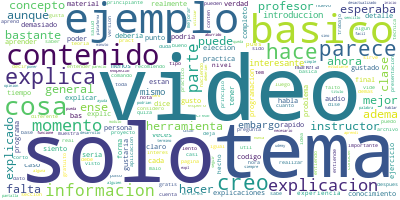

In [24]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list([' '.join(map(str, l)) for l in df_news['comment_cleaned']]))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


Now we need to build the *corpus* and the *dictionary* that gensim need to work, to do that we need to pass a list of list of tokens

In [25]:
# las palabras "curso,clase" son stopwords

In [26]:
df_news['comment_cleaned'].iloc[200:210]

200                                                                                                                                                                                                                                                                 [rapido, apuntes, practico, demostrativo, educacional, funcionan, enlac]
201                                                                                                                                                                                                                       [videos, excesivamente, cortos, plano, soldar, piezas, tarjetas, listado, material, existe, tienda, digital, sirv]
202                                                                                                                                                                                                                                                                                                               [aprendio, cosas, general]
2

In [27]:
dictionary = Dictionary(df_news['comment_cleaned'].to_list())
dictionary.compactify()
# Filter extremes
#dictionary.filter_extremes(no_below=5, no_above=0.3)#, keep_n=10000)
#dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.filter_extremes(no_below=5, no_above=0.2, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(text) for text in df_news['comment_cleaned'].to_list()]

# MODELADO

Comparando:
Latent Dirichlet Allocation (LDA), 
Latent semantic analysis (LSA), 
Hierarchical Dirichlet Process (HDP)

Para evaluar los topics, usamos **topic coherence** (una medida de interpretación de topics).

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [28]:
%%capture
!pip install pyLDAvis==2.1.2

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from collections import Counter
import numpy as np
from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
#from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import corpora

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import os, re, operator, warnings
warnings.filterwarnings('ignore')  
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [30]:
# LDA MODEL

In [31]:
def display_topics(model, model_type="lda"):
    for topic_idx, topic in enumerate(model.print_topics()):
        print ("Topic %d:" % (topic_idx))
        if model_type== "hdp":
            print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
        else:
            print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")

Find out the optimal number of topics for the LDA model based on the coherence metric:

In [44]:
from tqdm import tqdm_notebook

def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in tqdm_notebook(range(1, limit), 
                         total=limit-1, 
                         desc="Evaluating graph"):
        lm = LdaModel(corpus=corpus, chunksize=2000000, num_topics=num_topics, id2word=dictionary, iterations = 2000, passes=10, random_state = seed)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

Evaluating graph:   0%|          | 0/30 [00:00<?, ?it/s]

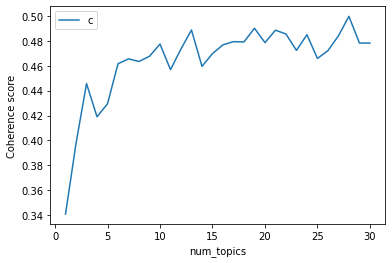

In [45]:
ldalist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['comment_cleaned'].to_list(), limit=31)

For this model it seems that  10, again we must to check the keywords too.

In [47]:
from tqdm import tqdm_notebook

def evaluate_best_seed(dictionary, corpus, texts, num_topics):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    random_seeds = np.random.randint(100000, size=(30))

    cm_max=0
    lda_max=0
    seed_max=0
    lda_list=[]
    c_v=[]

    for seed in tqdm_notebook(random_seeds, 
                         total=len(random_seeds), 
                         desc="LDA processing"):
        ldamodel_temp = LdaModel(corpus=corpus, chunksize=2000000, num_topics=num_topics, id2word=dictionary, iterations = 2000, passes=10, random_state = seed)
        lda_list.append(ldamodel_temp)
        cm = CoherenceModel(model=ldamodel_temp, texts=texts, dictionary=dictionary, coherence='c_v')
        cm_temp = cm.get_coherence()
        c_v.append(cm_temp)
        if cm_temp>cm_max:
          lda_max=ldamodel_temp
          seed_max=seed
          cm_max=cm_temp
        
    # Show graph
    x = range(len(random_seeds))
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lda_max, seed_max

LDA processing:   0%|          | 0/30 [00:00<?, ?it/s]

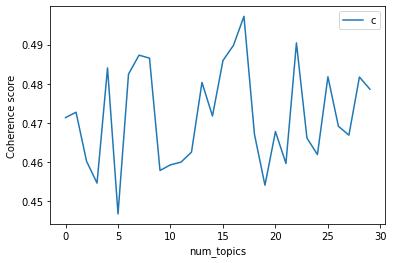

19176

In [48]:
num_topics=10
ldamodel, best_seed = evaluate_best_seed(dictionary=dictionary, corpus=corpus, texts=df_news['comment_cleaned'].to_list(), num_topics=num_topics)
doc_lda = ldamodel[corpus]
best_seed

In [77]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.test.utils import datapath
from gensim.models.ldamodel import LdaModel
import shutil

# Save model to disk.
!rm -rf model
!mkdir model
!rm -rf {udemy_folder + '/model'}
ldamodel.save("model/lda.model")

try:
  shutil.copytree('model', udemy_folder + '/model')
except:
  pass

# Load a potentially pretrained model from disk.
ldamodel = LdaModel.load("model/lda.model")

In [72]:
%%capture
!pip install pyLDAvis==2.1.2
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [73]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
7      0.07 -0.05       1        1 13.48
0      0.07 -0.04       2        1 12.41
4     -0.01  0.06       3        1 10.76
8      0.03 -0.02       4        1 10.47
3      0.03 -0.06       5        1 10.27
9      0.02 -0.01       6        1  9.88
2     -0.03  0.14       7        1  9.46
5      0.01  0.07       8        1  8.85
6      0.02 -0.03       9        1  8.74
1     -0.22 -0.06      10        1  5.66, topic_info=            Term     Freq    Total Category  logprob  loglift
586        audio   547.00   547.00  Default    30.00    30.00
311       basico 1,291.00 1,291.00  Default    29.00    29.00
79        videos 1,258.00 1,258.00  Default    28.00    28.00
354      momento   720.00   720.00  Default    27.00    27.00
140        cosas 1,259.00 1,259.00  Default    26.00    26.00
..           ...      ...      ...      ...      ...      ...
91   informacion    48.69   966.07  Topic10    -5.32    -0.12
311       basico    48.91 1,291.18  Topic10    -5.31    -0.40
157         creo    46.30 1,064.53  Topic10    -5.37    -0.26
222        poder    38.02   446.47  Topic10    -5.56     0.41
42         gusto    35.03   377.03  Topic10    -5.65     0.50

[791 rows x 6 columns], token_table=      Topic  Freq     Term
term                      
3301     10  0.98    about
569       3  0.01    aburr
569       4  0.93    aburr
569       7  0.04    aburr
761       1  0.07   acento
...     ...   ...      ...
152       6  0.30  youtube
152       7  0.01  youtube
152       8  0.04  youtube
152       9  0.04  youtube
152      10  0.02  youtube

[2805 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 5, 9, 4, 10, 3, 6, 7, 2])

In [70]:
# Print the fist 6 Keywords in the 10 topics
ldamodel.print_topics(num_topics, 6)

[(0,
  '0.034*"videos" + 0.025*"contenido" + 0.020*"audio" + 0.011*"parece" + 0.010*"calidad" + 0.010*"video"'),
 (1,
  '0.024*"momento" + 0.010*"ejercicios" + 0.010*"moment" + 0.010*"claro" + 0.009*"interes" + 0.008*"ejemplos"'),
 (2,
  '0.024*"falta" + 0.020*"explicacion" + 0.016*"eleccion" + 0.015*"temas" + 0.015*"informacion" + 0.014*"basico"'),
 (3,
  '0.018*"video" + 0.016*"ahora" + 0.010*"parece" + 0.009*"mejor" + 0.009*"solo" + 0.007*"paso"'),
 (4,
  '0.023*"conceptos" + 0.019*"ejemplos" + 0.011*"mejor" + 0.011*"podria" + 0.010*"teoria" + 0.009*"basicos"'),
 (5,
  '0.029*"basico" + 0.016*"demasiado" + 0.015*"bas" + 0.013*"explicacion" + 0.013*"creo" + 0.012*"esperaba"'),
 (6,
  '0.027*"cosas" + 0.015*"hacer" + 0.009*"forma" + 0.009*"ejemplos" + 0.008*"aprender" + 0.008*"explicar"'),
 (7,
  '0.015*"explica" + 0.012*"ense" + 0.011*"profesor" + 0.011*"instructor" + 0.011*"cosas" + 0.010*"tiempo"'),
 (8,
  '0.032*"solo" + 0.013*"explica" + 0.011*"mejor" + 0.009*"falta" + 0.008*"hac

### Comparing the Model Coherence of the Best Models

we made 3 models, now let's compare each other's  coherence

In [78]:
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [79]:
lda_coherence = CoherenceModel(topics=ldatopics, texts=df_news['comment_cleaned'].to_list(), dictionary=dictionary, window_size=10).get_coherence()
lda_coherence

0.32514755824780817

We can see that the **LdaModel** model **with 8 topics** has the higher value of
coherence

In [80]:
display_topics(ldamodel)

Topic 0:
videos contenido audio parece calidad video profesor tema instructor veces 

Topic 1:
momento ejercicios moment claro interes ejemplos falta pract explicado that 

Topic 2:
falta explicacion eleccion temas informacion basico hace tema nivel creo 

Topic 3:
video ahora parece mejor solo paso basico creo espa introduccion 

Topic 4:
conceptos ejemplos mejor podria teoria basicos temas practica aunque ejemplo 

Topic 5:
basico demasiado bas explicacion creo esperaba bastante solo mejor temas 

Topic 6:
cosas hacer forma ejemplos aprender explicar solo veces interesante aprendi 

Topic 7:
explica ense profesor instructor cosas tiempo creo preguntas explicar hace 

Topic 8:
solo explica mejor falta hace puede hacer instructor podria material 

Topic 9:
basico esperaba video cosas falta final menos gratis puede informacion 



It looks like the topics are:
* Topic 0: felicitaciones
* Topic 1: expectativas
* Topic 2: experiencia
* Topic 3: contenido
* Topic 4: instructor
* Topic 5: material
* Topic 6: video
* Topic 7: lenguaje
* Topic 8: ejercicios
* Topic 9: titulo
* Topic 10: temas
* Topic 11: explicación


Let´s check the keyword when we selecting another number of topics (14)

# Classifiying all documents

now that we have been select the best model and topics number, is time to assign a topic to each document, means **cluster** according to the topics

In [81]:
from tqdm.notebook import tqdm_notebook

def format_topics_sentences(ldamodel=0, doc_lda=None, texts=0):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in tqdm_notebook(enumerate(doc_lda), total=len(doc_lda)):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic_number', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel, doc_lda=doc_lda, texts=df_news['comment_cleaned'].to_list())



  0%|          | 0/18883 [00:00<?, ?it/s]

In [82]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic_number', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic_number,Topic_Perc_Contrib,Keywords,Text
0,0,4.00,0.85,"conceptos, ejemplos, mejor, podria, teoria, basicos, temas, practica, aunque, ejemplo","[introduccion, deberian, hacerlo, dirigido, fotos, rp]"
1,1,4.00,0.55,"conceptos, ejemplos, mejor, podria, teoria, basicos, temas, practica, aunque, ejemplo","[explican, mayori]"
2,2,0.00,0.92,"videos, contenido, audio, parece, calidad, video, profesor, tema, instructor, veces","[pronto, evaluarlo, comparandolo, calidad, bajo, pueden, descargar, archivos, estan, sonido, malo, escucha, turbi]"
3,3,5.00,0.58,"basico, demasiado, bas, explicacion, creo, esperaba, bastante, solo, mejor, temas","[detallado, menos, leido, calidad, seria, superior, tema, explicar, leer, men]"
4,4,7.00,0.67,"explica, ense, profesor, instructor, cosas, tiempo, creo, preguntas, explicar, hace","[parece, podria, algun, peque, repaso, terminos, comunes, ademas, ejempl]"
5,5,9.00,0.89,"basico, esperaba, video, cosas, falta, final, menos, gratis, puede, informacion","[parte, profesor, mismo, gratis, especializado, hacking, igualmente, explic]"
6,6,1.00,0.87,"momento, ejercicios, moment, claro, interes, ejemplos, falta, pract, explicado, that","[gusto, hacking, python, aprende, python, hacking]"
7,7,5.00,0.85,"basico, demasiado, bas, explicacion, creo, esperaba, bastante, solo, mejor, temas","[habla, hacking, apartados, solo, decepcion]"
8,8,1.00,0.95,"momento, ejercicios, moment, claro, interes, ejemplos, falta, pract, explicado, that","[introduccion, breve, rapida, lenguaje, programacion, python, auditoria, informatica, final, breve, ejemplo, hacer, cumplido, exactamente, expectativas, reconocer, tutor, esforzado, involucrado, ejemplos, lenguaj]"
9,9,3.00,0.90,"video, ahora, parece, mejor, solo, paso, basico, creo, espa, introduccion","[parecio, super, personas, quieran, iniciarse, lenguaje, programacion, python]"


In [83]:
topic_vec = np.array([0] * num_topics) 
print(topic_vec)
topic_vec[0]=10
print(topic_vec)


[0 0 0 0 0 0 0 0 0 0]
[10  0  0  0  0  0  0  0  0  0]


In [84]:
from tqdm import tqdm_notebook

#corpus_i = corpus[1000]
corp_list = []
for ii,doc_lda_ii in tqdm_notebook(enumerate(doc_lda), 
                         total=len(corpus), 
                         desc="Processing records"):
  #top_topics = (lda_model.get_document_topics(corp_ii,
  #                                      minimum_probability=0.0)
  #)
  #topic_vec = [top_topics[i][1] if top_topics[i][1]>0.1 else 0 for i in range(num_topics)]
  topic_vec = [0] * num_topics
  for yy,zz in doc_lda_ii:
    #if zz>0.1:
      topic_vec[yy] = zz

  corp_list.append(topic_vec)

Processing records:   0%|          | 0/18883 [00:00<?, ?it/s]

## Análisis de topicos

In [100]:
dg_topics = pd.DataFrame(corp_list)
dg_topics.tail(10)

,0,1,2,3,4,5,6,7,8,9
18873,0.02,0.02,0.02,0.02,0.82,0.02,0.02,0.02,0.02,0.02
18874,0.02,0.02,0.02,0.02,0.02,0.02,0.82,0.02,0.02,0.02
18875,0.02,0.02,0.02,0.59,0.02,0.02,0.25,0.02,0.02,0.02
18876,0.13,0.00,0.36,0.00,0.00,0.48,0.00,0.00,0.00,0.00
18877,0.03,0.70,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03
18878,0.02,0.02,0.02,0.82,0.02,0.02,0.02,0.02,0.02,0.02
18879,0.00,0.28,0.00,0.32,0.00,0.00,0.00,0.35,0.00,0.00
18880,0.03,0.03,0.03,0.03,0.03,0.03,0.77,0.03,0.03,0.03
18881,0.58,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.31
18882,0.01,0.01,0.60,0.01,0.01,0.01,0.01,0.01,0.28,0.01


In [101]:
df_all = pd.merge(df_news, dg_topics.add_prefix('topic_'), left_index=True, right_index=True,)
df_all.tail()

,index,id,course,rating,comment,user,tag,comment_cleaned,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
18878,174120,44039526,2241124,1.50,El video de corta cada 30 segundos,Marcelo Vergara,neg,"[video, corta, cada, segund]",0.02,0.02,0.02,0.82,0.02,0.02,0.02,0.02,0.02,0.02
18879,174124,42312208,2241124,3.50,"Aplica el sentido común.La experiencia que aporta . Puntos claves para saber emprender. Características del vendedor, honestidad, claridad, confianza, querer Vender.",Jose Manuel Torres Segade,neg,"[aplica, comu, experiencia, aporta, puntos, claves, saber, emprender, caracteristicas, vendedor, honestidad, claridad, confianza, querer, vend]",0.00,0.28,0.00,0.32,0.00,0.00,0.00,0.35,0.00,0.00
18880,174126,40788704,2241124,3.00,"Creí que podía ser mas completo, pero me equivoqué",Cristian Vera,neg,"[crei, podia, completo, equivoqu]",0.03,0.03,0.03,0.03,0.03,0.03,0.77,0.03,0.03,0.03
18881,174137,34694642,2241124,3.50,El contenido es breve y muy bueno para quienes se inician como asesores inmobiliarios. Los videos son de regular calidad.,Lourdes Gallardo,neg,"[contenido, breve, inician, asesores, inmobiliarios, videos, regular, cal]",0.58,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.31
18882,174140,93644240,3202322,3.00,"Solo se explica la conexión web, sería lo suyo explicar la app descargada.",Janira Cumbajin,neg,"[solo, explica, conexion, seria, explicar, descarg]",0.01,0.01,0.60,0.01,0.01,0.01,0.01,0.01,0.28,0.01


In [102]:
len(df_news),len(dg_topics), len(df_all)

(18883, 18883, 18883)

In [103]:
df_all.to_csv("udemy_reviews_with_topics.csv.zip", 
           index=False, 
           compression="zip")

try:
  shutil.copy('udemy_reviews_with_topics.csv.zip', udemy_folder + '/udemy_reviews_with_topics.csv.zip')
except:
  pass

In [104]:
dg_topics.sum(axis=1).sample(10)

1935    1.00
1343    1.00
17109   1.00
3738    1.00
15092   1.00
1834    1.00
2086    0.96
3257    1.00
7261    1.00
7216    0.92
dtype: float64

In [105]:
((dg_topics.astype(bool)==False).sum(axis=1)==num_topics).sum()

0

In [106]:
len(dg_topics)

18883

<BarContainer object of 10 artists>

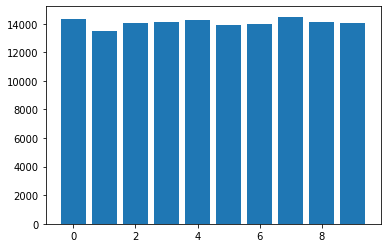

In [107]:
import matplotlib.pyplot as plt
plt.bar(dg_topics.columns, dg_topics.astype(bool).sum())

<BarContainer object of 10 artists>

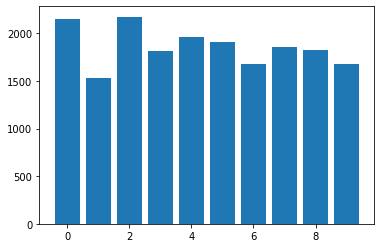

In [108]:
import matplotlib.pyplot as plt
plt.bar(dg_topics.columns, dg_topics.sum())

We selected the ldamodel with 12 topics and asigned a dominant topic to each document, now let map each topic with a label 

first let's create the dictionary

In [109]:
label_dicc = {0:'felicitaciones', 1:'expectativas', 2:'experiencia', 3: 'contenido', 4:'instructor', 5:'material', 6:'video', 
              7:'lenguaje', 8:'ejercicios', 9: 'titulo', 10:'temas', 11:'explicación'}

label_dicc = {0:"1_mas_detalles",
1:"2_pocos_ejemplos",
2:"3_mejorar_explicacion",
3:"4_nada",
4:"5_version",
5:"6_elecciones",
6:"7_demasiado_basico",
7:"8_calidad_de_video",
8:"9_mas_informacion",
9:"10_interesante",
}

In [110]:
df_dominant_topic['Dominant_Topic_number'] = df_dominant_topic['Dominant_Topic_number'].astype('int64')

In [112]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic_number'].map(label_dicc)

df_dominant_topic.to_csv("udemy_reviews_dominant.csv.zip", 
           index=False, 
           compression="zip")

try:
  shutil.copy('udemy_reviews_dominant.csv.zip', udemy_folder + '/udemy_reviews_dominant.csv.zip')
except:
  pass

df_dominant_topic.sample(10)

,Document_No,Dominant_Topic_number,Topic_Perc_Contrib,Keywords,Text,Dominant_Topic
539,539,4,0.50,"conceptos, ejemplos, mejor, podria, teoria, basicos, temas, practica, aunque, ejemplo","[comprado, gabriel, recomiendo, pense, gabriel, participaria, hace, persona, parece, debio, aclarar, inicio, alerta, gabriel, participa, requisitos, mostrados, publicidad, mencionan, seria, util, estudiantes, algun, conocimiento, basico, estadistica, requieren, conocimientos, habilidades, especificas, cierto, tener, nivel, alto, estadistica, inferencial, graduados, estadistica, necesitamos, menos, nivel, maestria, entender, perdida, tiempo, intentar, entender, conocimientos, previos, elevados, estadistica, inferencial, menos, bivariante, quedaran, atascados, concepto, distribuciones, conjuntas, supuesto, conocer, probabilidad, dedillo, marginales, conjunto, independencia, condicionalidad, conocer, titulo, menciona, python, claro, apenas, lenguaje, solo, temas, desarrolla, programacion, justo, profesora, pudo, desarrollar, programacion, logre, entender, volviendo, leer, parte, teorica, clases, tipo, magistral, profesor, estudiantes, miran, meramente, demostrativas, igual, wikipedia, adquirir, ...]",5_version
3616,3616,8,0.35,"solo, explica, mejor, falta, hace, puede, hacer, instructor, podria, material","[juan, ignacio, experto, consumado, tema, problema, disipa, detalles, agregan, tema, principal, ademas, claro, linuxero, creo, deberia, neutral, pues, mundo, tipos, tecnologias, proxmox, capaz, soportar, creo, podria, modifcar, hacerlo, consiso, asumir, menos, escuchas, expertos, linux, demasiado, extension, referente, backups, falto, seria, complementara, hardware, disponible, mercado, utilizar, freenas, hacer, explicacion, atemorizo, tener, critica, momentos, sigues, sale, ejemplo, deberia, editar, video, solo, poner, ejemplos, funcionen, demas, solo, confunde, agradezco, asesoria, pues, ayudo, entender, aspectos, comprendi]",9_mas_informacion
4106,4106,4,0.82,"conceptos, ejemplos, mejor, podria, teoria, basicos, temas, practica, aunque, ejemplo","[mucha, teoria, poca, pract]",5_version
2566,2566,3,0.37,"video, ahora, parece, mejor, solo, paso, basico, creo, espa, introduccion","[mediados, fecha, desactualiz]",4_nada
18606,18606,4,0.38,"conceptos, ejemplos, mejor, podria, teoria, basicos, temas, practica, aunque, ejemplo","[contenido, import]",5_version
3349,3349,9,0.52,"basico, esperaba, video, cosas, falta, final, menos, gratis, puede, informacion","[punto, vista, solo, haciendo, acercamiento, tecnologi]",10_interesante
2358,2358,4,0.87,"conceptos, ejemplos, mejor, podria, teoria, basicos, temas, practica, aunque, ejemplo","[eleccion, aunque, comparto, estilo, instructor, util, expl]",5_version
3368,3368,2,0.77,"falta, explicacion, eleccion, temas, informacion, basico, hace, tema, nivel, creo","[principante, tema, parece, conten]",3_mejorar_explicacion
5253,5253,3,0.93,"video, ahora, parece, mejor, solo, paso, basico, creo, espa, introduccion","[introduccion, carga, tintas, parte, dise, desarrollo, vende, nota, autor, dise, ador, desarroll]",4_nada
57,57,0,0.82,"videos, contenido, audio, parece, calidad, video, profesor, tema, instructor, veces","[manera, interesante, usar, metasploit]",1_mas_detalles


In [113]:
df_dominant_topic.isna().sum()

Document_No              0
Dominant_Topic_number    0
Topic_Perc_Contrib       0
Keywords                 0
Text                     0
Dominant_Topic           0
dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4eb23c3d0>],
      dtype=object)

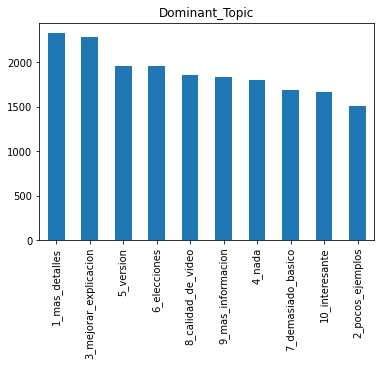

In [114]:
df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar', subplots=True)

,Dominant_Topic,Text
0,5_version,"[introduccion, deberian, hacerlo, dirigido, fotos, rp]"
1,5_version,"[explican, mayori]"
29,5_version,"[faltan, ejemplos, contenido, pobr]"


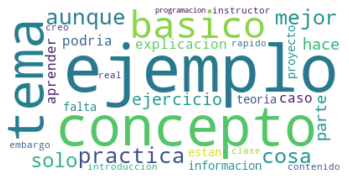

,Dominant_Topic,Text
2,1_mas_detalles,"[pronto, evaluarlo, comparandolo, calidad, bajo, pueden, descargar, archivos, estan, sonido, malo, escucha, turbi]"
11,1_mas_detalles,"[encuentro, cortos, videos, rapido, principi]"
14,1_mas_detalles,"[sonido, videos, tenia, mucha, calidad, resto, interes]"


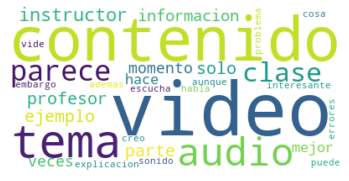

,Dominant_Topic,Text
3,6_elecciones,"[detallado, menos, leido, calidad, seria, superior, tema, explicar, leer, men]"
7,6_elecciones,"[habla, hacking, apartados, solo, decepcion]"
15,6_elecciones,"[empieza, ensenar, preparar, entorno, frustante, pasar, hora, escogiendo, compras, decidesdes, llevarlo, empieze, dese, letra, dejandote, perd]"


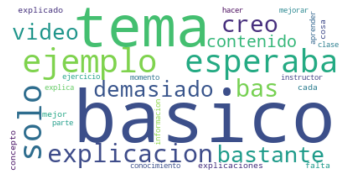

,Dominant_Topic,Text
4,8_calidad_de_video,"[parece, podria, algun, peque, repaso, terminos, comunes, ademas, ejempl]"
12,8_calidad_de_video,"[decepcionado, muchisimo, cuenta, dice, titulo, master, hacking, python, consiste, ense, base, python, puede, aprender, pagina, oficial, conocimientos, programacion, cualquier, lenguaje, luego, peque, ratito, ense, usar, unas, librerias, externas, obtener, informacion, basica, explicar, practicamente, puede, hacer, dat]"
16,8_calidad_de_video,"[enpieza, luego, complicado, seguirlo, mucash, veces, adjunta, eirnes, ebusca, codigo, fuent]"


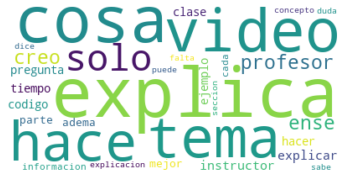

,Dominant_Topic,Text
5,10_interesante,"[parte, profesor, mismo, gratis, especializado, hacking, igualmente, explic]"
31,10_interesante,"[segun, punto, vista, explica, acerca, programacion, dreamweaver, configuracion, mismo, creo, alguien, novato, costaria, poder, seguir, fuerz]"
47,10_interesante,"[siento, hacen, falta, cosas, ense, herramienta, implementar, quedo, corta, c]"


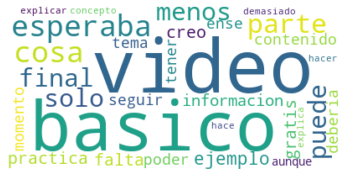

,Dominant_Topic,Text
6,2_pocos_ejemplos,"[gusto, hacking, python, aprende, python, hacking]"
8,2_pocos_ejemplos,"[introduccion, breve, rapida, lenguaje, programacion, python, auditoria, informatica, final, breve, ejemplo, hacer, cumplido, exactamente, expectativas, reconocer, tutor, esforzado, involucrado, ejemplos, lenguaj]"
22,2_pocos_ejemplos,"[librerias, desactualiz]"


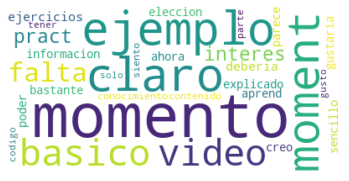

,Dominant_Topic,Text
9,4_nada,"[parecio, super, personas, quieran, iniciarse, lenguaje, programacion, python]"
18,4_nada,"[noto, cosas, explica, programar, ocasiones, hace, orden, resulta, confuso, programar, alguien, mejor, video, youtube, avanzado, espero, explicacion, avanz]"
21,4_nada,"[texto, peque, podria, mejorar, editando, video, eliminando, barra, herramientas, abaj]"


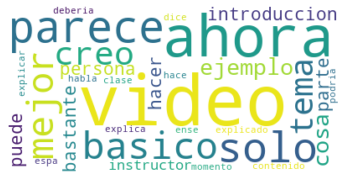

,Dominant_Topic,Text
10,9_mas_informacion,"[publicitan, hacking, python, solo, preambulo, final, solo, codigo, frente, dice, hizo, siento, estaf]"
23,9_mas_informacion,"[rapido, explicando, avance, codigo, pantalla, peque, cuesta, leer, codig]"
25,9_mas_informacion,"[podria, haber, sido, mejor, menos, pes]"


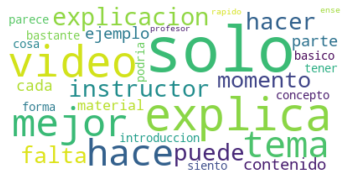

,Dominant_Topic,Text
13,3_mejorar_explicacion,"[hizo, largo, repetitivo, cualquier, manera, agradezco, aprend]"
20,3_mejorar_explicacion,"[temas, super, interesantes, embargo, creo, muchisimas, areas, oportunidad, mejorar, pase, clase, falta, punch, explicacion, demasiado, codigo, espagueti, forzar, vista, seguir, codig]"
65,3_mejorar_explicacion,"[falta, informacion, alguna, funcion, general]"


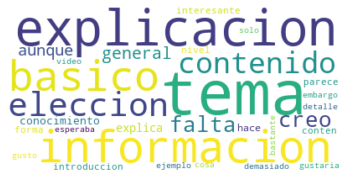

,Dominant_Topic,Text
17,7_demasiado_basico,"[interesante, profesor, niega, compartir, ejemplo, imparte, ofrece, ejemplo, capado, ense, clases, lamentable, primera, pasa, vida, recomiendo, profesor, reserva, informacion]"
26,7_demasiado_basico,"[corto, considere, incluia, tecnicas, grabacion]"
40,7_demasiado_basico,"[ultimo, bloque, faltan, detalles, forma, hacer, login, videos, anteriores, aparece, agradecerian, refrescarlo, hecho, falta, introduccion, powershell, test, entran, sentencias, explican, clases, seria, interesante, dedicarle, powershell, unas, clases, directamente, meter, bloque, powershell, basico, darte, unas, nociones, basicas, conocer, aspectos, basicos, office, faltan, nociones, basicas, powershell]"


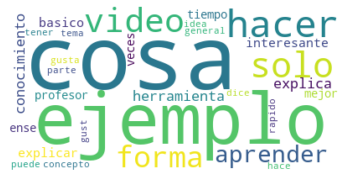

In [116]:
% matplotlib inline

topics = df_dominant_topic['Dominant_Topic'].unique()

for topic in topics:
  df_dominant_filtered = df_dominant_topic[df_dominant_topic['Dominant_Topic']==topic][["Dominant_Topic","Text"]]
  display(df_dominant_filtered.head(3))
  # Import the wordcloud library
  from wordcloud import WordCloud
  # Join the different processed titles together.
  long_string = ','.join(list([' '.join(map(str, l)) for l in df_dominant_filtered['Text']]))
  # Create a WordCloud object
  wordcloud = WordCloud(background_color="white", max_words=30, contour_width=3, contour_color='steelblue')
  # Generate a word cloud
  wordcloud.generate(long_string)
  # Visualize the word cloud
  wordcloud.to_image()
  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()


In [117]:
df_news['labels'] = df_dominant_topic['Dominant_Topic']
df_news['label_confidence'] = df_dominant_topic['Topic_Perc_Contrib']
df_news["labels"].fillna("X",inplace=True)

Let's examine some text and its topics

In [118]:
df_news[['comment', 'labels']].head(10)

,comment,labels
0,como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,5_version
1,Explican poco... se lee la mayoría,5_version
2,"es muy pronto para evaluarlo, comparandolo con la calidad de otros cursos este es bajo, no se pueden descargar los archivos ya que no estan en PDF y el sonido es malo, se escucha turbio.",1_mas_detalles
3,"Excelente, muy detallado. Si fuera menos « leído » la calidad sería superior! El tema da para explicar más y leer menos",6_elecciones
4,"Me parece que podria dar algun pequeño repaso de terminos comunes, ademas de dar mas ejemplos",8_calidad_de_video
5,Una parte del curso fue algo que el profesor mismo tiene en otro curso gratis.\nPero lo especializado a Hacking está igualmente bien explicado.,10_interesante
6,"No me gusto. Más que Hacking con Python... era aprende Python, de hacking poco y nada.",2_pocos_ejemplos
7,habla de hacking y son dos apartados que solo son web. DECEPCIONANTE.,6_elecciones
8,"Es una introducción breve y rápida al lenguaje de programación Python. No es un curso de Auditoria informática, ya que al final del curso se da un breve ejemplo de como hacer Scraping.No ha cumplido exactamente con mis expectativas pero he de reconocer que el tutor se ha esforzado e involucrado en los ejemplos del lenguaje.",2_pocos_ejemplos
9,Me pareció super bien el curso para las personas que quieran iniciarse en el lenguaje de programación python,4_nada


In [119]:
df_news[ df_news['labels'] == '10_interesante'].sort_values(by='label_confidence',ascending=False).head(5)

,index,id,course,rating,comment,user,tag,comment_cleaned,labels,label_confidence
12421,113338,69720720,2681366,1.50,"Primero de todo el titulo es un poco engañoso. Que el curso se llame master en machine learning que es lo que me interesaba y realmente no se vea nada de machine learning ha sido un poco decepcionante. Al principio era en plan veremos como limpiar datos, veremos como aplicarlo a machine learning, etc y por ello me quede hasta el final (aunque por el temario de curso no me diese esa impresión, pero bueno dije al principio hará un repaso de los lenguajes y se irá acercando más como decía al principio).\nEl segundo punto es que encuentro que el curso no está conexo. Es decir que veo que al final se ha ordenado de otra forma. Da la impresión que por los comentarios, primero tuviese que ir todo lo de R y luego todo lo de Python. Además a veces oías algo del estilo ""como vimos al final de la unidad anterior"" cuando a lo mejor hace dos temas que lo vimos o por ejemplo en la unidad 65 (La estadística, la base para\ncualquier analista de datos) es como si fuese sacado de otro curso porque al iniciar el video en el video se aprecian cosas tipo summary(data$mpg) o str(data$cylinders) que no lo hemos visto y empieza diciendo ""como acabamos de ver"". Dices bueno esto no tendrá importancia, lo que requiere es lo que vendrá a continuación. Pero ves que no, que como datos usa data$mpg que no sabemos ni como se obtiene, si mediante paquete o ese data y ese mpg viene de alguna instrucción o de donde. \nEl tercer punto y algo más positivo, es que a pesar de esto, me pareció que supo explicar muy bien tanto en el video como en el material proporcionado y poner unos ejemplos sencillos y claros. Es por esta parte que añadí la media estrella más, pero si no iba de cabeza a la estrella por todo lo comentado al principio que sinceramente me ha decepcionado mucho",Noel Mendez Lison,neg,"[primero, titulo, enga, llame, master, machine, learning, interesaba, realmente, machine, learning, sido, decepcionante, principio, plan, veremos, limpiar, datos, veremos, aplicarlo, machine, learning, ello, quede, final, aunque, temario, diese, impresion, dije, principio, hara, repaso, lenguajes, acercando, decia, principio, segundo, punto, encuentro, conexo, decir, final, ordenado, forma, impresion, comentarios, primero, luego, python, ademas, veces, oias, estilo, vimos, final, unidad, anterior, mejor, hace, temas, vimos, ejemplo, unidad, estadistica, base, paracualquier, analista, datos, sacado, iniciar, video, video, aprecian, cosas, tipo, summary, data, data, cylinders, visto, empieza, diciendo, acabamos, dices, tendra, importancia, requiere, vendra, continuacion, datos, data, sabemos, obtiene, mediante, paquete, data, viene, alguna, instruccion, ...]",10_interesante,0.99
2765,24960,7190572,412108,2.00,"Muy superficial. Esperaba bastante más de un ""curso"" porque lo que dice se puede resumir tranquilamente en un par de folios. La información que da está bien para tenerla en un blog personal, pero ni de lejos se le puede catalogar de ""curso"". Son un conjunto de obviedades.\n¿Qué mercados son los mejores para operar? ¿qué activos? ¿cuándo podemos considerar un activo lo suficientemente líquido para operar con él, cómo lo elegimos? ¿qué software podemos usar? ¿cómo hacemos un backtesting? ¿qué broker debemos elegir, con qué características? ¿qué apalancamiento? Etc. Ninguna de estas preguntas es tratada en el curso.\nAdemás, y aunque el sistema se base en la observación de precio y volumen no se puede obviar lo que ""todo el mundo ve"" y de lo que está pendiente, de hecho me parece una absoluta contradicción en un sistema que se basa en hacer ""lo que el dinero hace"" y me estoy refiriendo a la famosa media de 200 que se tiene en cuenta por casi todo el mundo, o los niveles psicológicos donde el precio toma una cifra redonda, y apurando algo más, los retrocesos de fibonacci, es decir, zonas que ""todo el mundo mira"" y en las que el precio puede c

### let's see the distribution of topics


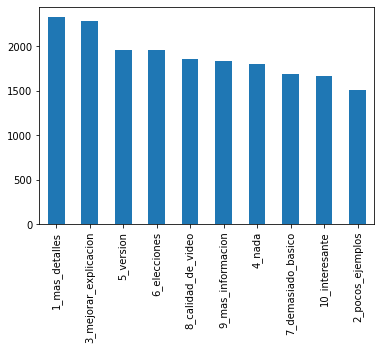

In [120]:
ax = df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')
plt.show()

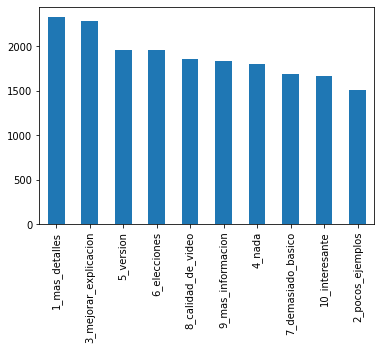

In [121]:
ax = df_news['labels'].value_counts().plot(kind='bar')
plt.show()

The topis are almost balanced, so we are good

finally that we have our models set up, as well as analyzed, we can go
ahead to visualizing them.

In [122]:
import pyLDAvis

pyLDAvis.enable_notebook()

In [123]:
# %%time
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
7      0.07 -0.05       1        1 13.48
0      0.07 -0.04       2        1 12.41
4     -0.01  0.06       3        1 10.75
8      0.03 -0.02       4        1 10.46
3      0.03 -0.06       5        1 10.29
9      0.02 -0.01       6        1  9.90
2     -0.03  0.14       7        1  9.47
5      0.01  0.07       8        1  8.84
6      0.02 -0.03       9        1  8.74
1     -0.22 -0.06      10        1  5.66, topic_info=            Term     Freq    Total Category  logprob  loglift
586        audio   547.00   547.00  Default    30.00    30.00
311       basico 1,291.00 1,291.00  Default    29.00    29.00
79        videos 1,258.00 1,258.00  Default    28.00    28.00
354      momento   720.00   720.00  Default    27.00    27.00
140        cosas 1,259.00 1,259.00  Default    26.00    26.00
..           ...      ...      ...      ...      ...      ...
91   informacion    48.66   966.28  Topic10    -5.32    -0.12
311       basico    48.89 1,291.40  Topic10    -5.31    -0.40
157         creo    46.28 1,064.65  Topic10    -5.37    -0.26
222        poder    38.01   446.58  Topic10    -5.56     0.41
42         gusto    35.02   377.18  Topic10    -5.65     0.50

[791 rows x 6 columns], token_table=      Topic  Freq     Term
term                      
3301     10  0.98    about
569       3  0.01    aburr
569       4  0.93    aburr
569       7  0.04    aburr
761       1  0.07   acento
...     ...   ...      ...
152       6  0.30  youtube
152       7  0.01  youtube
152       8  0.04  youtube
152       9  0.04  youtube
152      10  0.02  youtube

[2804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 5, 9, 4, 10, 3, 6, 7, 2])

In [124]:
len(df_news),df_news.isna().sum()

(18883, index               0
 id                  0
 course              0
 rating              0
 comment             0
 user                1
 tag                 0
 comment_cleaned     0
 labels              0
 label_confidence    0
 dtype: int64)

In [125]:
# NOW.... GROUP BY COURSE
# AND GROUP BY LABEL THEN

In [126]:
df_by_course = df_news.groupby("course")
df_agg_by_course = pd.DataFrame(index=df_news["course"].unique())

In [127]:
 df_agg_by_course["comments"] = df_by_course['comment_cleaned'].agg(sum)
 df_agg_by_course.sample(10)

,comments
2540074,"[ahora, descontento, creo, impartiendo, primero, irritable, segundo, entiende, correctamente, materia, explica, super, rapido, diciendo, decir, detiene, haciendo, pautas, correct]"
2119410,"[dado, llevar, vide, segunda, parte, explicada, demasiado, rapida, saltos, temario, desconciertan, mencionar, siquiera, menciona, diagramas, gantt]"
1803800,"[corto, pract, extremadamente, ligero, basico, necesaria, informacion, reinventar, vida, recomendable, personas, inician, desarrollo, personal, eleccion, herramientas, vali, titulo, genera, expectativas, real, tono, transmite, motivacion, siendo, coaching, considero, faltaron, herramientas, directrices, aumentar, felicidad, traves, serotonina, endorfina, dopamina, resumen, coaching, acompa, generar, hormonas, felicidad, motivacion, reinventarse, renovarse, cuerpo, alma, hacerse, rutina, definir, pl, mediocre, habia, encontrado, misma, informacion, desarrollada, siti, introductori, introduccion, basico, gust, contenidos, escasos, brev, gusto, bastante, depende, creo, refresco, debo, ponerlo, practica, diario, tras, objet, really, rewarding, reset, goals, guided, through, process, agradecer, tiempo, dedicado, realizar, obstante, podria, mejorar, ofreciendo, temas, ayude, hacer, introspeccion, profunda, acerca, mismo, entiendo, media, ...]"
2002350,"[empieza, despues, grabacion, dictado, plataforma, demas, contenido, programacion, bas, siento, redund, momento, menciona, introduccion, basica, motivacional, programacion, siempre, aprende, nuev, coach, hablando, programacion, cuso, deberia, llamarse, motivacion, programar, similar, minimo, contenido, fundamentos, programacion, esperaba, leer, titul, trata, recortes, videos, varias, presentaciones, orden, unico, punto, interesante, programacion, orientada, objetos, parece, cort, orador, toco, programacion, real, realmente, crei, video, enfocado, parte, teorica, tecnica, programacion, ahora, viendo, parece, acorde, titulo, descripcion, provechoso, gustaria, dieran, listado, done, debemos, empezar, estudiar, videos, tedioso, habian, ejemplos, solo, explicacion, audit, coleccion, consejos, empezar, programacion, parece, refrito, varias, conferencias, videos, sueltos, gustado, hecho, expresamente, principi, pareci, desgracia, aunque, ...]"
2763660,"[codigo, veces, funciona, sabe, version, nod, video, veia, difuso, varias, parte, parte, contenido, calidad, nombrar, alguno, metodos, llamadas, echo, post, necesario, ponerle, create, dado, hace, post, redundante, agrado, locuto, clases, conocimiento, contenido, refinaria, rescat, parece, poder, hablar, estudiar, cualquier, quiera, comprar, mirar, servira, profesor, practicas, conoc, termin, malo, resulto, aparte, letra, cosas, explica, solo, obvi, nivel, general, bastante, deja, gran, percepcion, idea, acerca, funciona, tecnologia, quizas, faltado, fallos, errores, aparecian, video, sido, editado, eliminado, dichas, partes, echado, menos, explicaciones, teoricos, sirven, ciertas, cosas, alla, usarlas, simpl, relacionado, relacionado, javascript, puro, puede, poner, ultimas, estrellas, punto, vista, typescript, untema, largo, complejo, ...]"
2785852,"[enfoca, wordpress, plugins, especif, principiantes, contrari, experiencia, revis, pues, esperaba, informacion, puntual, aprender, utilizar, plataform, novato, viene, cero, encontrarse, programa, adsense, conceptos, resulta, complicado, obstante, poniendole, avanzando, tient, partiendo, pones, tocar, codig, gratis, regular, esper]"
883398,"[captions, could, have, included, english, subtitl]"
4164414,"[simplemente, termina, explicaciones, basicamente, video, youtub]"
2513228,"[aprender, cosas, basicas, inkscape, ademas, tips, dise, personajes, problema, actualiza, hace, tiempo, ademas, instructor, videos, tiempo, queda, callado, dificulta, seguir, ritmo, videos, poniendo, mucha, atencion, sumado, ocasiones, menciona, combinaciones, teclas, adivinando, cuales, volviendo, misma, parte, saber, correcta, equivocas, hiciste, asemeje, esperado

In [128]:
 df_agg_by_course["labels"] = df_by_course['labels'].apply(list)
 df_agg_by_course.sample(10)

,comments,labels
1249746,"[hola, recien, comienzo, conoc, considero, experto, ense, entusiasmo, puede, hacerse, aburrido, despues, tiempo, observ, sirve, complementos, tom]","[4_nada, 5_version, 8_calidad_de_video]"
2921598,"[entendible, hace, falta, estudiar, concept, gratuito, agradecido, instructor, darle, lado, dificil, seguir, queremos, comprenderlo, entend]","[7_demasiado_basico, 4_nada]"
119276,"[falta, mayor, profundidad, temas, trat]",[3_mejorar_explicacion]
2747300,"[crei, seria, mejor, desastre, dijo, podria, ense, ello, preparar, computadora, renderizar, videos, aprender, forma, hablar, repite, videos, bajar, abajo, abrase, oido, alguna, errores, viniendo, udemy, forma, rimbombante, anunciar, estafa, completa, conten, sirvio, conocer, software, puede, ocupar, recuperar, informacion, falto, sacar, informacion, platos, disco, duro, ojala, realice, tip]","[9_mas_informacion, 3_mejorar_explicacion]"
1176230,"[entendi, tratar, alguien, quiere, hacer, lanita, salirse, casa, papas, momento, tratado, fric, hablando, mismo, fragmentos, distintos, producidos, formatos, explicaciones, escuetas, notorio, planeo, solo, junto, monton, videos, tenia, sueltos, pegaba, momento, verdadera, perdida, tiempo, espero, conforme, avance, calidad, mejor, didactico, simple, preciso, duda, gran, ayuda, guia, pretendemos, emprend, repite, cosas, est, mucha, informacion, repetitiva, videos, pueden, mejor, incluso, hacerlos, demasiado, cortos, pueden, agrupar, hacerlos, completos, audio, variable, vide, choro, poca, calidad, informacion, salvo, tema, espiritualidad, demas, nefast, punto, vista, contenido, real, podria, haber, resumido, video, minutos, creador, hablara, ombligo, horas, video, repites, saciedad, mismos, conceptos, parece, creadores, amabilidad, filtrar, contenido, autopromocion, ...]","[1_mas_detalles, 2_pocos_ejemplos, 7_demasiado_basico, 1_mas_detalles, 1_mas_detalles, 1_mas_detalles, 9_mas_informacion, 9_mas_informacion, 8_calidad_de_video, 9_mas_informacion, 3_mejorar_explicacion, 3_mejorar_explicacion, 2_pocos_ejemplos, 7_demasiado_basico, 4_nada, 4_nada, 6_elecciones, 1_mas_detalles, 6_elecciones, 1_mas_detalles, 1_mas_detalles, 8_calidad_de_video, 7_demasiado_basico, 1_mas_detalles, 9_mas_informacion, 7_demasiado_basico, 2_pocos_ejemplos, 5_version, 1_mas_detalles, 4_nada, 3_mejorar_explicacion, 2_pocos_ejemplos, 2_pocos_ejemplos, 9_mas_informacion, 1_mas_detalles, 3_mejorar_explicacion, 3_mejorar_explicacion, 9_mas_informacion, 2_pocos_ejemplos, 6_elecciones, 4_nada, 1_mas_detalles, 1_mas_detalles, 2_pocos_ejemplos, 5_version, 3_mejorar_explicacion, 1_mas_detalles, 6_elecciones, 5_version, 9_mas_informacion, 2_pocos_ejemplos, 10_interesante, 9_mas_informacion, 4_nada, 1_mas_detalles, 5_version, 9_mas_informacion, 5_version, 10_interesante, 7_demasiado_basico, 6_elecciones, 10_interesante]"
2789068,"[parece, interesante, podria, mejor, abordar, mejor, tem, dice, ejercicios, basicos, cumplen, cometido, decepcion, pudo, mejor, organizado, temas, ejemplos, desactualiz, cosas, explica, confusas, facil, perder, hilo, poniendo, atencion, puede, facilmente, aprender, bastante, complet, verdad, podria, mejor, aunque, hace, monotomo, verd, rapido, aunque, comandos, falta, creo, explicar, comando, funcion, ademas, basa, interfaz, grafica, github]","[5_version, 2_pocos_ejemplos, 5_version, 9_mas_informacion, 5_version, 3_mejorar_explicacion]"
2440534,"[solo, explica, codigo, implement]",[9_mas_informacion]
3002822,"[interesante, dise, momento, cumple, espect, logro, instrucciones, vean, archivo, html, introductorio, explic, ense, montar, pagina, solo, crear, codig]","[9_mas_informacion, 8_calidad_de_video, 7_demasiado_basico, 9_mas_informacion]"
3715588,"[gustaria, didact, pues, interesante, absolutamente, idioma, lograre, mucha, practica, empe, aprend]","[7_demasiado_basico, 7_demasiado_basico]"
2802589,"[traba, hablar, contenido, muchisimo, diapositivas, pesimas, explicaciones, ayuda, hacer, ejemplos, dinam, instructora, falta, mej

In [130]:
df_agg_by_course.to_csv("udemy_reviews_aggregated.csv.zip", 
           index=False, 
           compression="zip")

try:
  shutil.copy('udemy_reviews_aggregated.csv.zip', udemy_folder + '/udemy_reviews_aggregated.csv.zip')
except:
  pass

# Log-odds-ratio, Informative Dirichlet